Iniziamo la creazione della rete importando tutte le librerie che ci occorrono per creare il modello

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Conv2D, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tkinter as tk
from PIL import Image, ImageDraw, ImageOps
import tensorflow_datasets as tfds
import tensorflow as tf
from IPython.display import display, HTML
from google.colab import output
import base64
import io

Carichiamo il dataset emnist e sistemiamo le immagini siccome il dataset le importa girate di 90 gradi e specchiate

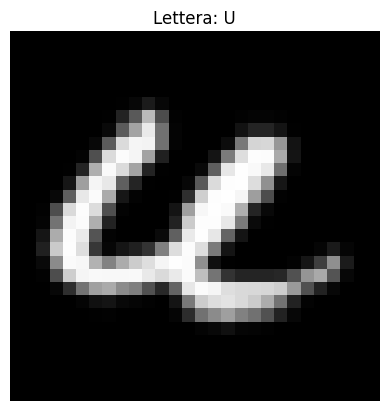

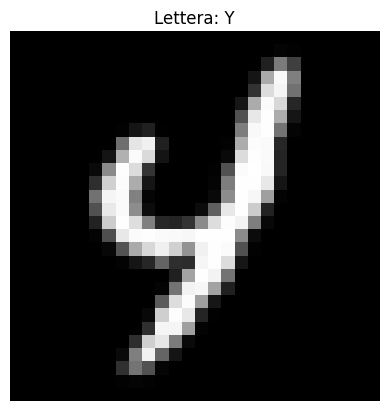

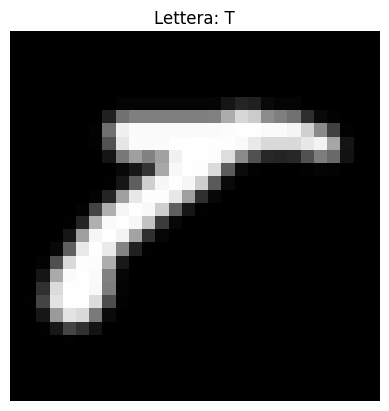

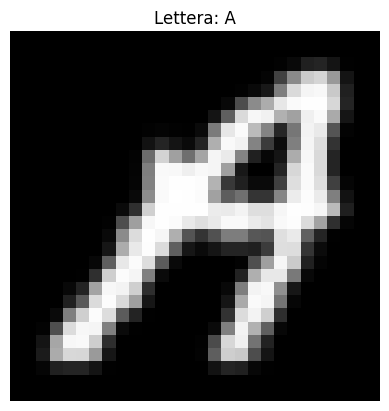

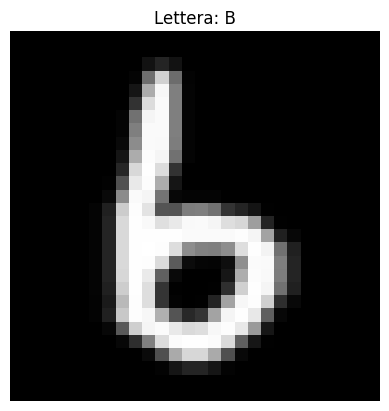

In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    'emnist/letters',
    split=['train', 'test'],
    as_supervised=True,
    with_info=True
)

def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.rot90(image, k=-1)
    image = tf.image.flip_left_right(image)
    label -= 1
    image = tf.expand_dims(image, -1)
    return image, label

batch_size = 32
ds_train = ds_train.map(preprocess).shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)

for images, labels in ds_train.take(1):
    for i in range(5):
        plt.imshow(images[i].numpy().squeeze(), cmap='gray')
        plt.title(f"Lettera: {chr(int(labels[i]) + 65)}")  # 0='A'
        plt.axis("off")
        plt.show()

Ora definiamo la struttura del modello:
Creiamo un conv2d per estrarre i dati importanti(controni, bordi, etc...), col max pooling estraiamo il dato più significativo in una matrice 2x2 ed infine col dropout evitiamo l'overfitting.

Lo ripetiamo un'altra volta.

Usiamo flatten per appiattire l'immagine prima del dense in modo che il modello la possa leggere.
Elaboriamo le info col dense, ultimo dropout ed infine in output mettiamo soft max siccome abbiamo un output classificabile con 26 neuroni siccome le lettere sono 26.

Poi assegnamo al modello le direttive come optimizer, loss (che sarà sparse_categorical_crossentropy, funzione di perdita utilizzata in problemi di classificazione multi-classe, dove le etichette target sono rappresentate come interi, ovvero gli indici delle classi, invece di vettori one-hot).

Infine definiamo l'allenamento per l'IA.

In [3]:
model = Sequential([
    Conv2D(32, (2, 2), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(64, (2, 2), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(26, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(ds_train,
                    epochs=10,
                    validation_data=ds_test)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
2775/2775 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step - accuracy: 0.6151 - loss: 1.2705 - val_accuracy: 0.8802 - val_loss: 0.3762
Epoch 2/10
2775/2775 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.8429 - loss: 0.4936 - val_accuracy: 0.8868 - val_loss: 0.3412
Epoch 3/10
2775/2775 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.8660 - loss: 0.4101 - val_accuracy: 0.9005 - val_loss: 0.3063
Epoch 4/10
2775/2775 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.8782 - loss: 0.3722 - val_accuracy: 0.9055 - val_loss: 0.2742
Epoch 5/10
2775/2775 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.8863 - loss: 0.3428 - val_accuracy: 0.9068 - val_loss: 0.2689
Epoch 6/10
2775/2775 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.8908 - loss: 0.3266 - val_accuracy: 0.9116 - val_loss: 0.2646
Epoch 7/10
2775/2775 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.8994 - loss: 0.3015 - val_accuracy: 0.9134 - val_loss: 0.2633
Epoch 8/10
2775/2775 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.9009 - loss: 0

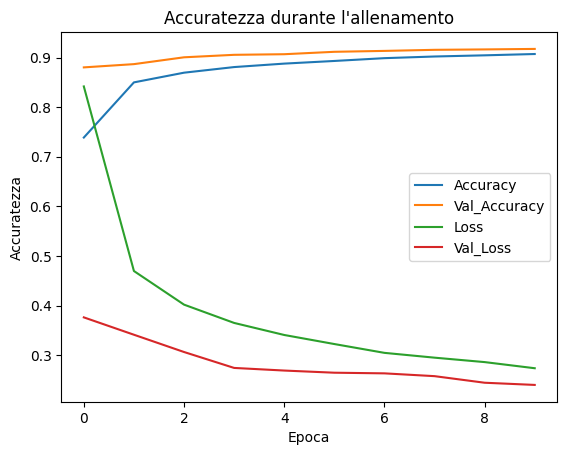

In [4]:
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val_Accuracy')
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val_Loss')
plt.title('Accuratezza durante l\'allenamento')
plt.xlabel('Epoca')
plt.ylabel('Accuratezza')
plt.legend()
plt.show()

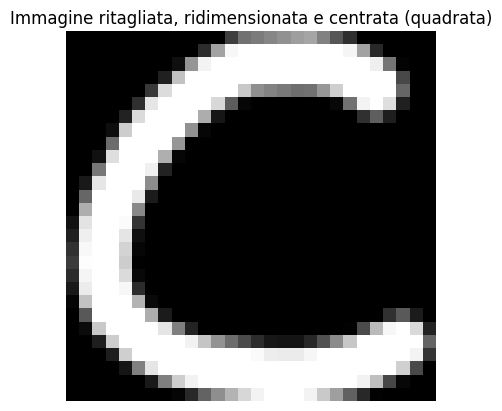

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


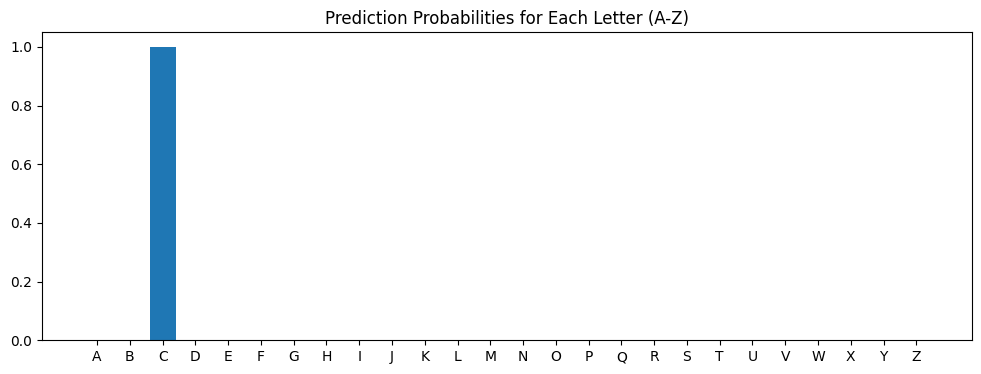

In [26]:
from IPython.display import display, HTML
from google.colab import output
import base64
import io
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

canvas_html = """
<canvas id="canvas" width="280" height="280" style="border:1px solid black;"></canvas>
<br>
<button onclick="predict()">Predict</button>
<button onclick="clearCanvas()">Clear</button>

<script>
let canvas = document.getElementById('canvas');
let ctx = canvas.getContext('2d');
let drawing = false;

canvas.addEventListener('mousedown', () => { drawing = true; });
canvas.addEventListener('mouseup', () => { drawing = false; ctx.beginPath(); });
canvas.addEventListener('mouseout', () => { drawing = false; ctx.beginPath(); });

canvas.addEventListener('mousemove', (event) => {
  if (!drawing) return;
  ctx.lineWidth = 20;
  ctx.lineCap = "round";
  ctx.strokeStyle = "white";
  ctx.lineTo(event.offsetX, event.offsetY);
  ctx.stroke();
  ctx.beginPath();
  ctx.moveTo(event.offsetX, event.offsetY);
});

ctx.fillStyle = "black";
ctx.fillRect(0, 0, canvas.width, canvas.height);

function clearCanvas() {
  ctx.fillStyle = "black";
  ctx.fillRect(0, 0, canvas.width, canvas.height);
}

function predict() {
  const dataURL = canvas.toDataURL();
  google.colab.kernel.invokeFunction('notebook.predict_digit', [dataURL], {});
}
</script>
"""

display(HTML(canvas_html))

def preprocess_image(img):
    img = img.convert('L')
    img_array = np.array(img)
    non_black_pixels = np.where(img_array > 0)
    if non_black_pixels[0].size > 0:
        y_min, x_min = np.min(non_black_pixels[0]), np.min(non_black_pixels[1])
        y_max, x_max = np.max(non_black_pixels[0]), np.max(non_black_pixels[1])
        max_dim = max(y_max - y_min, x_max - x_min)
        center_x = (x_min + x_max) // 2
        center_y = (y_min + y_max) // 2
        new_x_min = max(0, center_x - max_dim // 2 - 2)
        new_x_max = min(img_array.shape[1], center_x + max_dim // 2 + 2)
        new_y_min = max(0, center_y - max_dim // 2 - 2)
        new_y_max = min(img_array.shape[0], center_y + max_dim // 2 + 2)
        crop_width = new_x_max - new_x_min
        crop_height = new_y_max - new_y_min
        max_crop_dim = max(crop_width, crop_height)
        if crop_width < max_crop_dim:
            diff = max_crop_dim - crop_width
            new_x_min = max(0, new_x_min - diff // 2)
            new_x_max = min(img_array.shape[1], new_x_max + (diff - diff // 2))
        if crop_height < max_crop_dim:
            diff = max_crop_dim - crop_height
            new_y_min = max(0, new_y_min - diff // 2)
            new_y_max = min(img_array.shape[0], new_y_max + (diff - diff // 2))
        cropped_img_array = img_array[new_y_min:new_y_max, new_x_min:new_x_max]
        cropped_img = Image.fromarray(cropped_img_array)
    else:
        cropped_img = img
    size = max(cropped_img.size)
    new_img = Image.new('L', (size, size), color=0)
    new_img.paste(cropped_img, ((size - cropped_img.size[0]) // 2, (size - cropped_img.size[1]) // 2))
    new_img = new_img.resize((28, 28))
    plt.imshow(new_img, cmap='gray')
    plt.title('Immagine ritagliata, ridimensionata e centrata (quadrata)')
    plt.axis('off')
    plt.show()
    img_array = np.array(new_img).astype('float32') / 255.0
    img_array = np.expand_dims(img_array, -1)
    return np.expand_dims(img_array, 0)

def predict_digit(data):
    data = data.split(',')[1]
    binary = base64.b64decode(data)
    img = Image.open(io.BytesIO(binary))
    processed_img = preprocess_image(img)
    prediction = model.predict(processed_img)[0]
    pred_class = np.argmax(prediction)
    confidence = np.max(prediction)
    pred_letter = chr(pred_class + 65)
    display(HTML(f"<h3>Predicted: {pred_letter} (Confidence: {confidence:.2%})</h3>"))
    plt.figure(figsize=(12, 4))
    plt.bar(range(26), prediction)
    plt.xticks(range(26), [chr(i + 65) for i in range(26)])
    plt.title('Prediction Probabilities for Each Letter (A-Z)')
    plt.show()

output.register_callback('notebook.predict_digit', predict_digit)


Con questo blocco possiamo visualizzare i pesi del modello

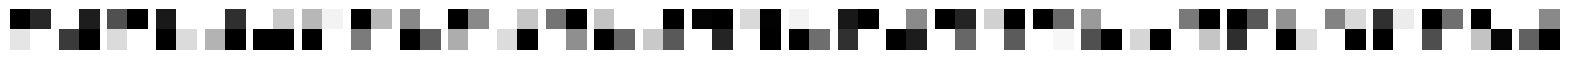

In [6]:
import matplotlib.pyplot as plt

# Prendi i pesi del primo layer conv2D
filters, biases = model.layers[0].get_weights()

# filters shape: (height, width, input_channels, num_filters)
num_filters = filters.shape[3]

fig, axes = plt.subplots(1, num_filters, figsize=(20,5))
for i in range(num_filters):
    f = filters[:, :, 0, i]  # prendi il filtro relativo al primo canale input
    axes[i].imshow(f, cmap='gray')
    axes[i].axis('off')
plt.show()

Crea un canvas 1020x280 per riconoscere tutte le lettere all'interno di una parola.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


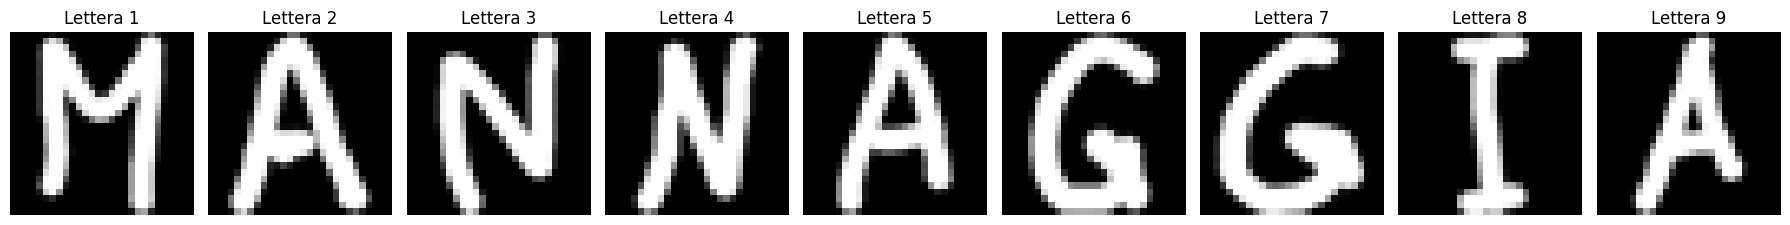

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


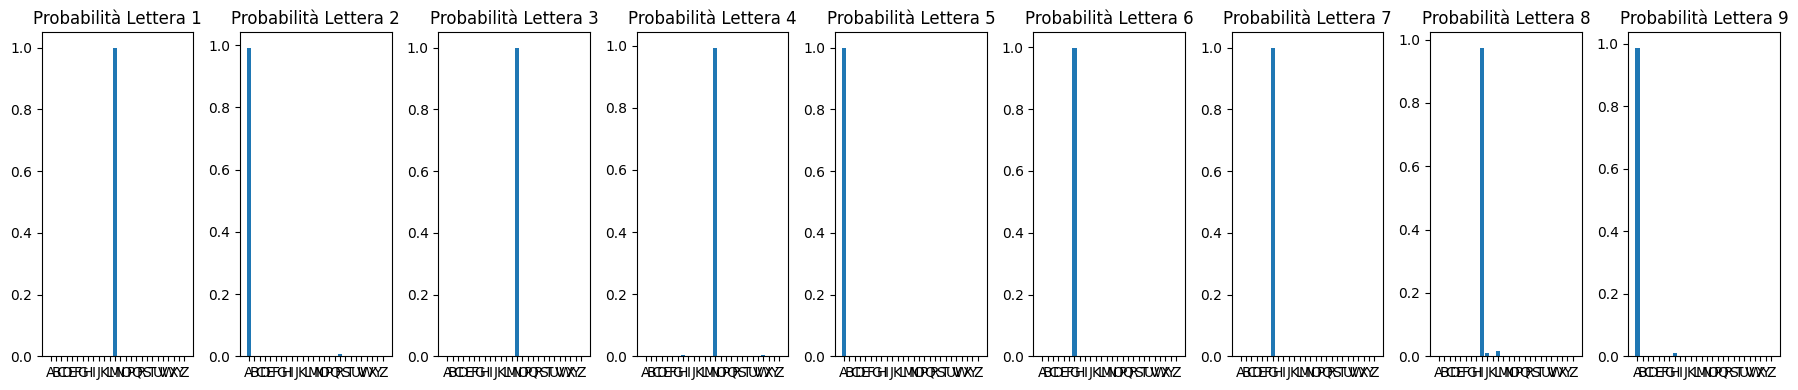

In [30]:
# --- HTML CANVAS 1020x280 ---
canvas_html = """
<canvas id="canvas" width="1020" height="280" style="border:1px solid black;"></canvas>
<br>
<button onclick="predict()">Predict</button>
<button onclick="clearCanvas()">Clear</button>
<script>
let canvas = document.getElementById('canvas');
let ctx = canvas.getContext('2d');
let drawing = false;

canvas.addEventListener('mousedown', () => { drawing = true; });
canvas.addEventListener('mouseup', () => { drawing = false; ctx.beginPath(); });
canvas.addEventListener('mouseout', () => { drawing = false; ctx.beginPath(); });

canvas.addEventListener('mousemove', (event) => {
  if (!drawing) return;
  ctx.lineWidth = 15;
  ctx.lineCap = "round";
  ctx.strokeStyle = "white";
  ctx.lineTo(event.offsetX, event.offsetY);
  ctx.stroke();
  ctx.beginPath();
  ctx.moveTo(event.offsetX, event.offsetY);
});

ctx.fillStyle = "black";
ctx.fillRect(0, 0, canvas.width, canvas.height);

function clearCanvas() {
  ctx.fillStyle = "black";
  ctx.fillRect(0, 0, canvas.width, canvas.height);
}

function predict() {
  const dataURL = canvas.toDataURL();
  google.colab.kernel.invokeFunction('notebook.predict_digit', [dataURL], {});
}
</script>
"""
display(HTML(canvas_html))

# --- PREPROCESSING PER UNA LETTERA ---
def preprocess_image(img):
    img = img.convert('L')
    img_array = np.array(img)
    non_black_pixels = np.where(img_array > 0)
    if non_black_pixels[0].size > 0:
        y_min, x_min = np.min(non_black_pixels[0]), np.min(non_black_pixels[1])
        y_max, x_max = np.max(non_black_pixels[0]), np.max(non_black_pixels[1])
        max_dim = max(y_max - y_min, x_max - x_min)
        center_x = (x_min + x_max) // 2
        center_y = (y_min + y_max) // 2
        new_x_min = max(0, center_x - max_dim // 2 - 2)
        new_x_max = min(img_array.shape[1], center_x + max_dim // 2 + 2)
        new_y_min = max(0, center_y - max_dim // 2 - 2)
        new_y_max = min(img_array.shape[0], center_y + max_dim // 2 + 2)
        crop_width = new_x_max - new_x_min
        crop_height = new_y_max - new_y_min
        max_crop_dim = max(crop_width, crop_height)
        if crop_width < max_crop_dim:
            diff = max_crop_dim - crop_width
            new_x_min = max(0, new_x_min - diff // 2)
            new_x_max = min(img_array.shape[1], new_x_max + (diff - diff // 2))
        if crop_height < max_crop_dim:
            diff = max_crop_dim - crop_height
            new_y_min = max(0, new_y_min - diff // 2)
            new_y_max = min(img_array.shape[0], new_y_max + (diff - diff // 2))
        cropped_img_array = img_array[new_y_min:new_y_max, new_x_min:new_x_max]
        cropped_img = Image.fromarray(cropped_img_array)
    else:
        cropped_img = img
    size = max(cropped_img.size)
    new_img = Image.new('L', (size, size), color=0)
    new_img.paste(cropped_img, ((size - cropped_img.size[0]) // 2, (size - cropped_img.size[1]) // 2))
    new_img = new_img.resize((28, 28))
    img_array = np.array(new_img).astype('float32') / 255.0
    img_array = np.expand_dims(img_array, -1)
    return np.expand_dims(img_array, 0), new_img # Restituisce anche l'immagine PIL ridimensionata e centrata

# --- SEGMENTAZIONE LETTERE ---
def segment_letters(img):
    img = img.convert('L')
    img_array = np.array(img)
    threshold = 50
    bin_img = (img_array > threshold).astype(np.uint8) * 255
    col_sum = np.sum(bin_img, axis=0)
    in_letter = False
    letter_bounds = []
    for i, val in enumerate(col_sum):
        if val > 0 and not in_letter:
            in_letter = True
            start = i
        elif val == 0 and in_letter:
            in_letter = False
            end = i
            if end - start > 5:
                letter_bounds.append((start, end))
    if in_letter:
        letter_bounds.append((start, len(col_sum)))
    letter_images = []
    for (start, end) in letter_bounds:
        letter_crop = img.crop((start, 0, end, img.height))
        letter_images.append(letter_crop)
    return letter_images

# --- PREDIZIONE PAROLA E LETTERE ---
def predict_digit(data):
    data = data.split(',')[1]
    binary = base64.b64decode(data)
    img = Image.open(io.BytesIO(binary))
    letter_imgs = segment_letters(img)

    predictions = []
    confidences = []
    processed_images_for_display = [] # Lista per memorizzare le immagini pre-processate per la visualizzazione

    for letter_img in letter_imgs:
        processed_img_array, processed_pil_img = preprocess_image(letter_img) # Ottiene sia l'array che l'immagine PIL
        processed_images_for_display.append(processed_pil_img) # Aggiunge l'immagine PIL alla lista
        prediction = model.predict(processed_img_array)
        pred_class = np.argmax(prediction)
        confidence = np.max(prediction)
        pred_letter = chr(pred_class + 65)
        predictions.append(pred_letter)
        confidences.append(confidence)

    # Visualizza le immagini delle lettere pre-processate
    plt.figure(figsize=(len(processed_images_for_display)*2, 4))
    for i, processed_img_pil in enumerate(processed_images_for_display):
        plt.subplot(1, len(processed_images_for_display), i+1)
        plt.imshow(processed_img_pil, cmap='gray')
        plt.title(f'Lettera {i+1}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

    word = ''.join(predictions)
    # Visualizza la parola riconosciuta
    display(HTML(f"<h3>Parola riconosciuta: {word}</h3>"))
    # Visualizza tutte le lettere riconosciute singolarmente
    for idx, (letter, conf) in enumerate(zip(predictions, confidences)):
        display(HTML(f"<p>Lettera {idx+1}: <b>{letter}</b> (Confidenza: {conf:.2%})</p>"))

    # Visualizza le probabilità per ogni lettera
    plt.figure(figsize=(len(letter_imgs)*2, 4))
    for i, letter_img in enumerate(letter_imgs):
        plt.subplot(1, len(letter_imgs), i+1)
        processed_img_array, _ = preprocess_image(letter_img) # Ottiene solo l'array per la predizione
        prediction = model.predict(processed_img_array)
        plt.bar(range(26), prediction[0])
        plt.xticks(range(26), [chr(j + 65) for j in range(26)])
        plt.title(f'Probabilità Lettera {i+1}')
        plt.tight_layout()
    plt.show()


output.register_callback('notebook.predict_digit', predict_digit)